# Installation

In [ ]:
!pip install TPTBox ruamel.yaml configargparse spineps hf-deepali

# Overview

This tutorial will give you an overview how to get from a DICOM dump to a processed Dataset with segmentations.

abbreviations:
POI: Point of interest

Steps:

(1) Dicom export to BIDS dataset

(2) Stitching

(3) Segmentation TotalVibeSegmentator, Spineps ...

(4) Points of Interest (POI) 

(5) Point registration

(6) Deformable Registration for diffrent breath holds compensation


## 1 Dicom export to BIDS dataset

Short overview:

A BIDS dataset is a file naming convection.

The following rules should be known and weakly enforced:

- A dataset folder should start with 'dataset-{YOUR-NAME}'
- The next level folder are:
  - rawdata: for all imaging data.
  - derivative: for all generated data, like segmentation.
A file should look like:

sub-{Subject name}_ses-{Session}_{key}-{value}*_{format}.{filetype}
- Subject name: Unique identifier 
- Session: Session id. Optional if there is only one session
- Any number of key-values. Keys are unique. The defined keys are here: https://bids-specification.readthedocs.io/en/stable/appendices/entities.html . Our tool enforces a certain order. See tutorial_BIDS_files.ipynb
- format: type of acquisition like ct, T2w, VIBE, MPRage
Do not use '_' in any key or values. 

See https://bids-specification.readthedocs.io/en/stable/ for detailed description what BIDS ist.

In [ ]:
from TPTBox.core.bids_files import entities_keys, formats

print('Known formats:\n','; '.join(formats))
print()
print()
print("Order of keys we enforce:\n", '; '.join(entities_keys.keys()))


This function extracts a dicom folder to a BIDS-like Niffty folder.

The names are created like this: DICOM:Key is given dicom key
      
`dataset-{NAME}/rawdate/sub-{DICOM:PatientID}/ses-{DICOM:StudyDate}/{format}/sub-{DICOM:PatientID}_ses-{DICOM:StudyDate}_sequ-{DICOM:SeriesNumber}_acq-{sag|ax|cor|iso}_{format}.nii.gz`


and a .json, where the and DICOM-Keys are saved.

To get {format} we use string matching and the dicom "SeriesDescription" key. As this is a free text this will not always work. Than we default to "mr" and you have to manually rename them.


For very large dataset you can use make_subject_chunks = n [int]. Than we put a additional folder with the first n letters between rawdata and the sub- folder.

In [ ]:
from pathlib import Path

from TPTBox.segmentation.TotalVibeSeg.auto_download import _download

path_to_dicom_dataset = Path("/media/data/robert/datasets/dicom_example/test/private/").absolute()
target_folder = Path(path_to_dicom_dataset).parent

#if not path_to_dicom_dataset.exists():
#    _download('https://github.com/robert-graf/TotalVibeSegmentator/releases/download/example/PixelPandemonium.zip',path_to_dicom_dataset, text="example")

dataset_name = Path(path_to_dicom_dataset).name.replace("_","-") # TODO Remove
dataset = target_folder / f"dataset-{dataset_name}"

In [ ]:
from TPTBox.core.dicom.dicom_extract import extract_dicom_folder

extract_dicom_folder(Path(path_to_dicom_dataset), dataset,use_session=True,n_cpu=10,skip_localizer=True)

## Example for https://data.mendeley.com/datasets/k57fr854j2/2
#extract_dicom_folder(Path(path_to_dicom_dataset), dataset,use_session=True,n_cpu=10,override_subject_name=lambda x,y: y.name.split("_")[-2],skip_localizer=True)

We have tool that automat scans Bids folders an creates a grouped dictionary, where you can pick out the relevant.

In [ ]:
from math import floor
from TPTBox import BIDS_FILE, BIDS_Global_info
from TPTBox.core.bids_constants import sequence_splitting_keys

print("if one of the values of these keys is diffrent, than it is considered a other sequence:", sequence_splitting_keys)
print("sub will alway split")

print("Lets search for candidate for merging. For this we have to remove the sequ-key from sequence_splitting_keys")
my_splitting_keys = sequence_splitting_keys.copy()
my_splitting_keys.remove("sequ")
my_splitting_keys.append("part")

bgi = BIDS_Global_info(dataset,["rawdata","derivative"],sequence_splitting_keys=my_splitting_keys)
stitching_candidate:list[BIDS_FILE] = []
epsilon = 0.2
for name, subj in bgi.iter_subjects():
    print('Subject identifier',name)
    q = subj.new_query()
    #Filter by some rules
    q.flatten()
    q.filter_filetype('nii.gz')
    q.unflatten()
    for fam in q.loop_dict():
        print(fam)
        for key, file_list in fam.items():
            if key == "mr":
                continue
            if len(file_list) == 1:
                continue
            # This code is only an example, where we group images with the same orientation and zoom, so we know what are potential stitching targets.
            # We use _format key as the initial split, so T1w and T2w will not be stiched
            matching_group = []
            for files in range(len(file_list)):
                f1 = file_list[files]
                if f1 is None:
                    continue
                grid1 = f1.get_grid_info()
                idx1 = int(f1.get("sequ", "0")) if f1.get("sequ", "0").isdigit() else 0
                if grid1 is None:
                    continue
                current_group = [f1]  # Start a new group with the current file
                for j in range(files + 1, len(file_list)):
                    f2 = file_list[j]
                    if f2 is None:
                        continue
                    grid2 = f2.get_grid_info()
                    if grid2 is None:
                        continue
                    idx2 = int(f2.get("sequ", "0")) if f1.get("sequ", "0").isdigit() else 0
                    if floor(idx1/100)!=(floor(idx2/100)):
                        continue
                    # Check if orientation matches
                    if grid1.orientation != grid2.orientation:
                        continue
                    # Check if zoom is within the tolerance
                    zoom_diff = [abs(z1 - z2) for z1, z2 in zip(grid1.zoom, grid2.zoom,strict=False)]
                    if all(diff <= epsilon for diff in zoom_diff):
                        current_group.append(f2)
                        file_list[j] = None # type: ignore
                # Add the group if it has more than one file
                if len(current_group) > 1:
                    stitching_candidate.append(current_group)
for files in stitching_candidate:
    print(files)

# 2 Stitching  
Torax/Fullbody images are often in chunks. We can stich them with the stitching function

In [21]:
from concurrent.futures import ProcessPoolExecutor

from TPTBox import to_nii
from TPTBox.stitching import stitching

derivative_folder = "rawdata_stiched"

def process_files(files):
    files = sorted(files)  # noqa: PLW2901
    sequ: str = (files[0].get("sequ", "") + "-" if "sequ" in files[0].info else "") + "stiched"  # type: ignore
    out_name = files[0].get_changed_path("nii.gz", info={"sequ": sequ}, parent=derivative_folder)
    if not out_name.exists():
        stitching(files, out=out_name, is_seg=False, is_ct=files[0].bids_format == "ct", dtype=to_nii(files[0]).dtype,match_histogram=True,)
        nii = to_nii(out_name)
        nii.apply_crop_(nii.compute_crop())
        nii.save(out_name)
# Test
#process_files(stitching_candidate[0])

# Execute the loop in parallel using a ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    executor.map(process_files, stitching_candidate)

[*] Save /media/data/robert/datasets/dicom_example/test/dataset-private/rawdata_stiched/sub-ANONPR99KJ1ON/ses-20240411/T1w/sub-ANONPR99KJ1ON_ses-20240411_sequ-701-stiched_acq-sag_T1w.nii.gz as uint16


[sub-ANONPR99KJ1ON_ses-20240411_sequ-401_acq-sag_T1w.['json', 'nii.gz']	 parent = rawdata, sub-ANONPR99KJ1ON_ses-20240411_sequ-402_acq-sag_T1w.['json', 'nii.gz']	 parent = rawdata, sub-ANONPR99KJ1ON_ses-20240411_sequ-403_acq-sag_T1w.['json', 'nii.gz']	 parent = rawdata]
[ ] resample_from_to: shape=(15, 784, 784),spacing=(3.3, 0.36, 0.36), origin=(25.43, -175.93, -134.62), ori=('L', 'A', 'S'), seg=False to shape=(15, 783, 2190),spacing=(3.3, 0.36, 0.36), origin=(27.79, -191.42, -640.82), ori=('L', 'A', 'S'), seg=False
[ ] resample_from_to: shape=(15, 784, 784),spacing=(3.3, 0.36, 0.36), origin=(29.55, -183.74, -385.78), ori=('L', 'A', 'S'), seg=False to shape=(15, 783, 2190),spacing=(3.3, 0.36, 0.36), origin=(27.79, -191.42, -640.82), ori=('L', 'A', 'S'), seg=False
[ ] resample_from_to: shape=(15, 784, 784),spacing=(3.3, 0.36, 0.36), origin=(25.31, -191.77, -641.21), ori=('L', 'A', 'S'), seg=False to shape=(15, 783, 2190),spacing=(3.3, 0.36, 0.36), origin=(27.79, -191.42, -640.82), ori=

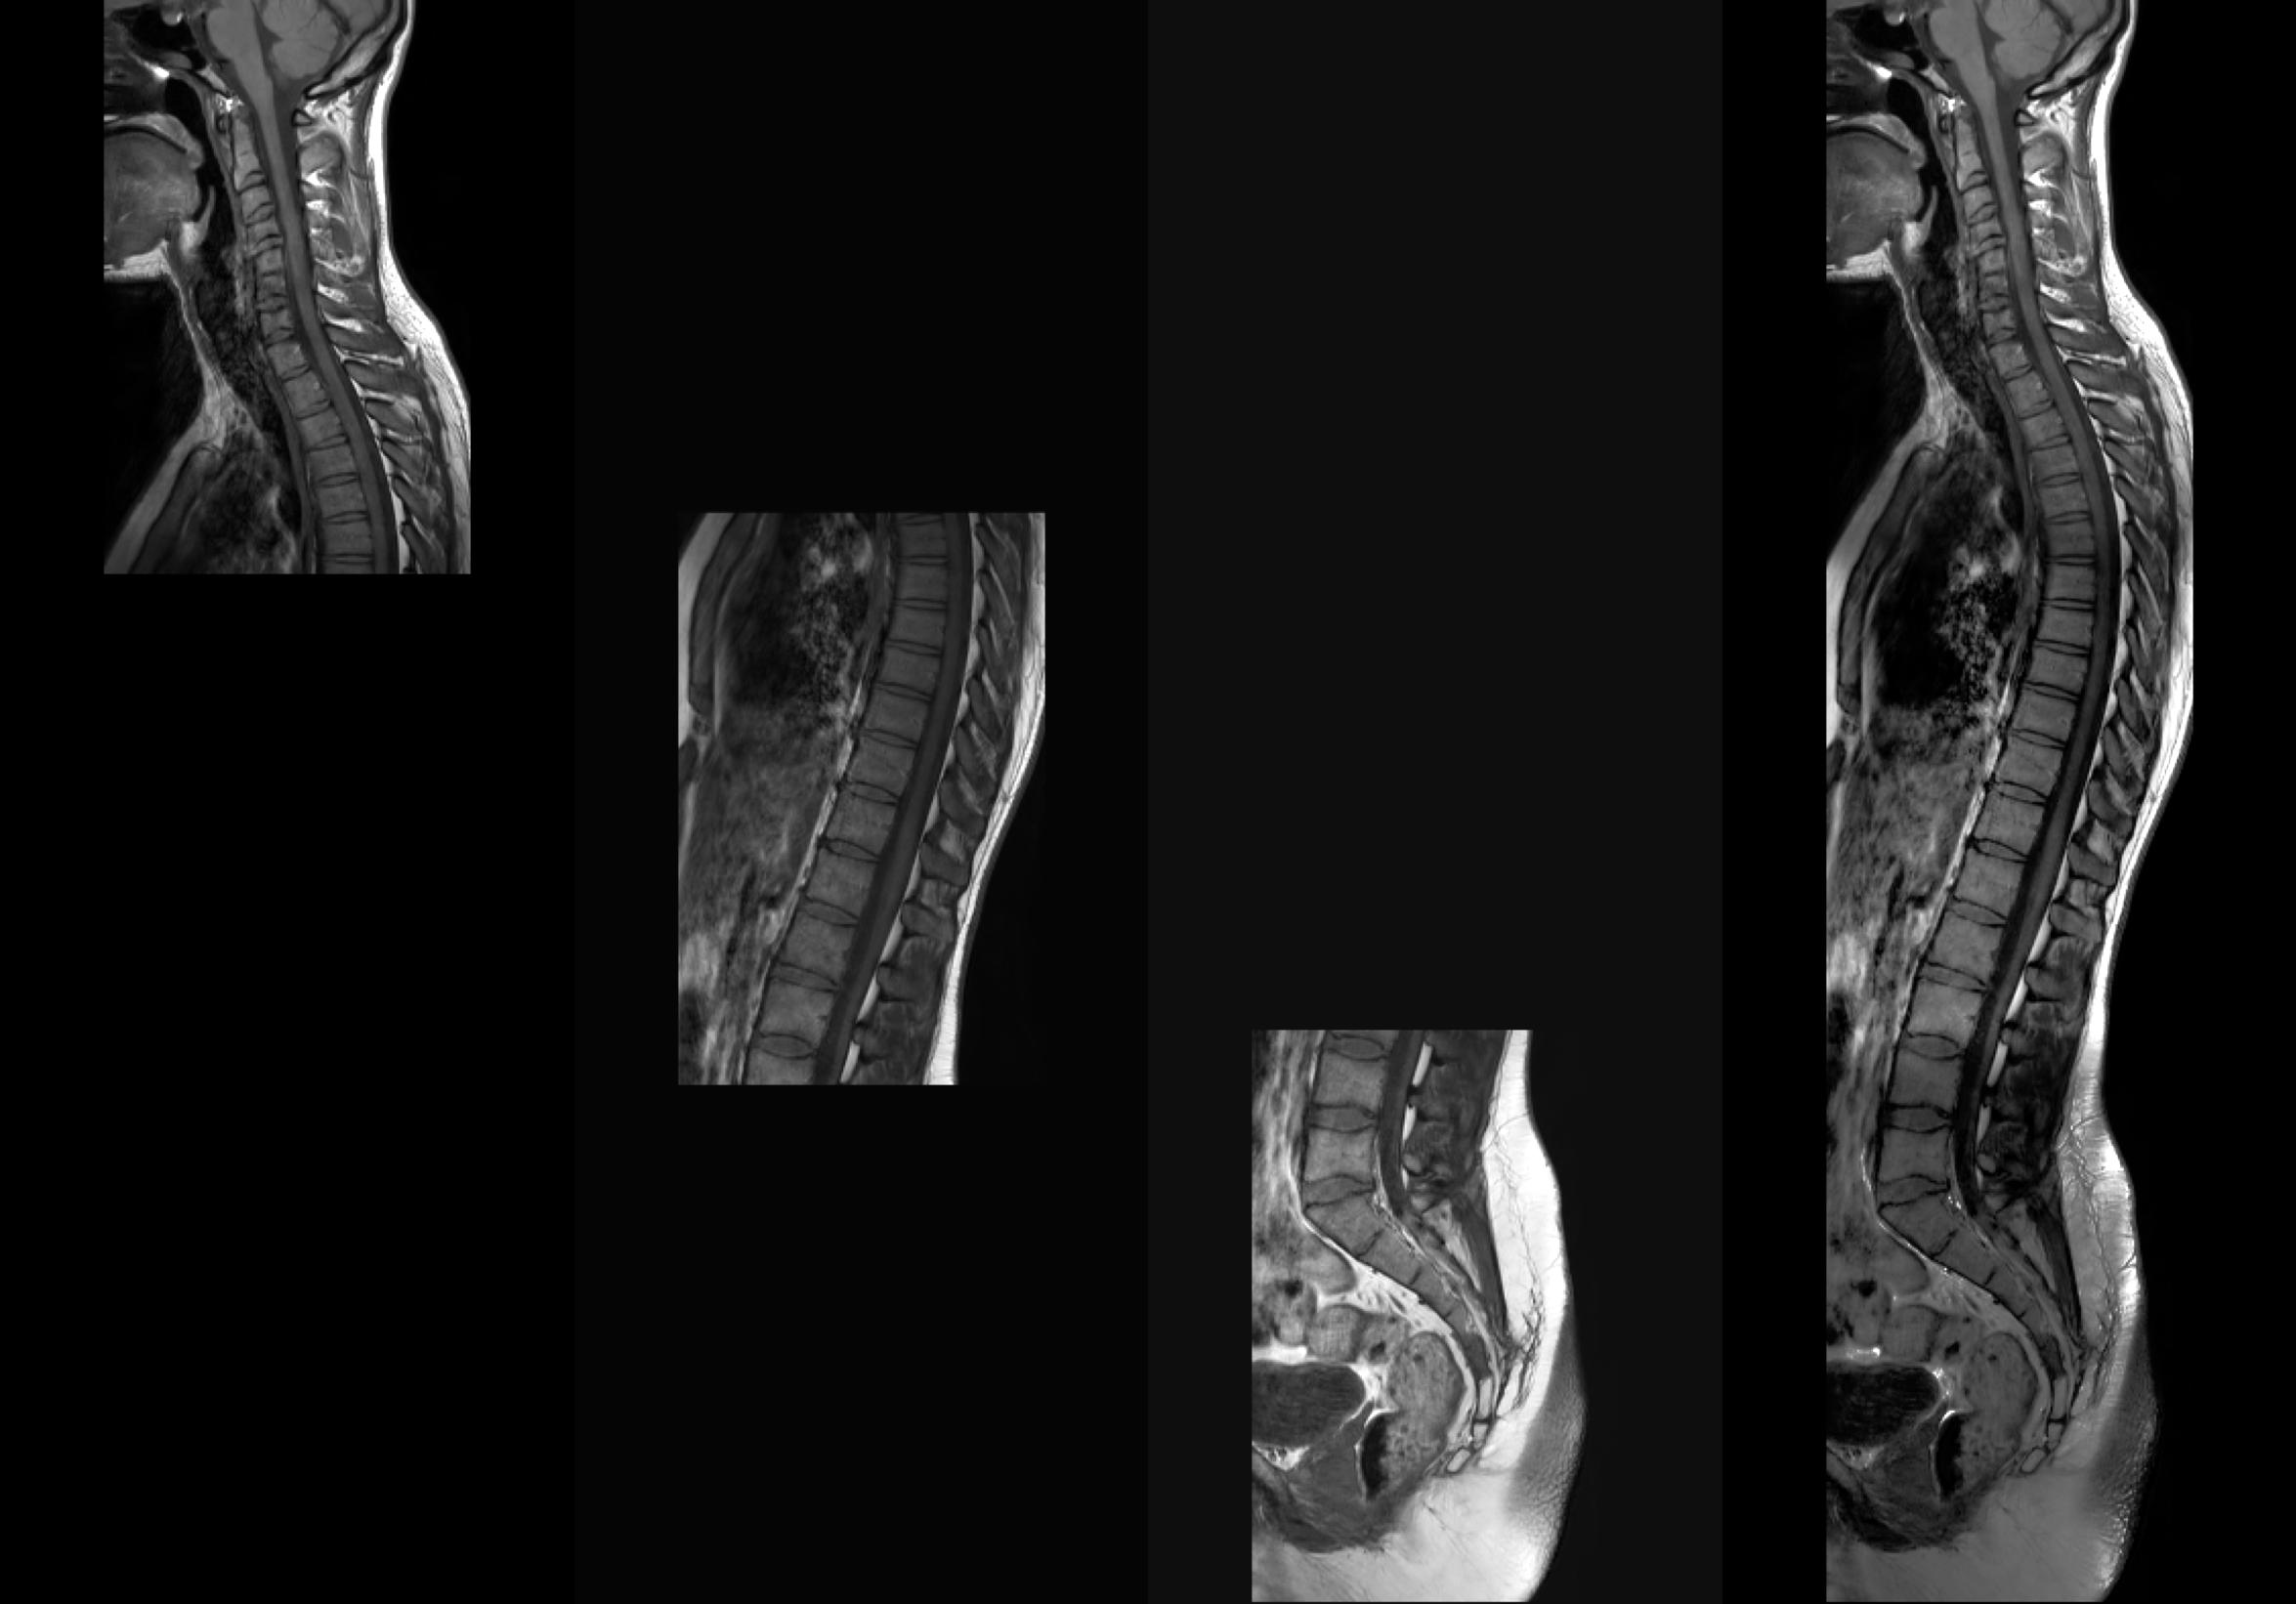

In [28]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

### make snapshot
out_img = Path("out.jpg")
files = stitching_candidate[0]
files = sorted(files)
print(files)
sequ: str = (files[0].get("sequ", "") + "-" if "sequ" in files[0].info else "") + "stiched"
t = files[0].get_changed_path("nii.gz", info={"sequ": sequ}, parent=derivative_folder)
a = [Snapshot_Frame(to_nii(i).resample_from_to(t,mode="constant"), sagittal=True) for i in files]
b = Snapshot_Frame(t,sagittal=True)

create_snapshot(out_img, [*a,b])
Image(filename=out_img)

# 3 Segmentation  

Note: by default we do not install Deep-learning stuff.

Install:

```pip install SPINEPS ruamel.yaml configargparse```

trouble shouting: nnunetv2==2.4.2


### TotalVibeSegmentator

https://arxiv.org/abs/2406.00125

https://github.com/robert-graf/TotalVibeSegmentator


In [ ]:
from TPTBox import BIDS_FILE
from TPTBox.segmentation import run_totalvibeseg

# run_totalvibeseg
# You can alos use a string/Path if you want to set the path yourself.
### Just making in and output path
dataset = target_folder / "dataset-PixelPandemonium"
in_file_dixon = BIDS_FILE(f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-water_dixon.nii.gz",dataset)
out_file_dixon = in_file_dixon.get_changed_path("nii.gz","msk",parent="derivative",info={"seg":"TotalVibeSegmentator","mod":in_file_dixon.bids_format})
####
run_totalvibeseg(in_file_dixon,out_file_dixon,override=False)



In [ ]:

from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(in_file_dixon, segmentation=out_file_dixon, sagittal=True, axial=True,axial_heights=[0.5],ignore_seg_for_centering=True)
create_snapshot(out_img, [a])
Image(filename=out_img)

In [ ]:

# run_totalvibeseg
# You can also use a string/Path if you want to set the path yourself.
### Just making in and output path
dataset = target_folder / "dataset-PixelPandemonium"
in_file = BIDS_FILE(f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-201-stiched_acq-ax_part-inphase_T2w.nii.gz",dataset)
out_file = in_file.get_changed_path("nii.gz","msk",parent="derivative",info={"seg":"TotalVibeSegmentator","mod":in_file.bids_format})
####
run_totalvibeseg(in_file,out_file,override=False)

In [ ]:

from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(in_file, segmentation=out_file, sagittal=True, axial=True,axial_heights=[0.2,.4,0.6],ignore_seg_for_centering=True)
create_snapshot(out_img, [a])
Image(filename=out_img)

## spineps

Spineps can segment spine images in a instance and semantic mask. Running automatic over a dataset is very opinionated, what to segment. 
TODO: make a way to manully define output paths

https://github.com/Hendrik-code/spineps/tree/main

In [ ]:
# If your model is BIDS compliant you can auto run spineps
#from TPTBox.segmentation import run_spineps_all
#run_spineps_all(dataset)


In [ ]:
# Pick a fitting model:
from spineps.models import modelid2folder_instance, modelid2folder_semantic

print('Available Semantic Models',modelid2folder_semantic())
print('Available Instance Models',modelid2folder_instance())

print(modelid2folder_semantic().keys())
print(modelid2folder_instance().keys())

### Just making in and output path
dataset = target_folder / "dataset-PixelPandemonium"
in_file = BIDS_FILE(f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz",dataset)
####

model_semantic = "t2w"
model_instance = "instance"
derivative_name = "derivative"


In [ ]:
from TPTBox.segmentation.spineps import run_spineps_single

#With 'ignore_compatibility_issues = True' you can force to run the soft ware
out_paths = run_spineps_single(
    in_file,
    dataset=dataset,
    model_semantic=model_semantic,
    model_instance=model_instance,
    derivative_name=derivative_name,
    ignore_compatibility_issues=False,use_cpu=False)
print(out_paths)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")
a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"],centroids=out_paths["out_ctd"], sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"],centroids=out_paths["out_ctd"], sagittal=True)
create_snapshot(out_img, [a,b])
Image(filename=out_img)

# 4 Point of intresst

We have a json file format, that can be rescaled like a niffty between loacal spaceses and to global space.

The file is human reable. Not the file and numpy start conting with 0, while ITKSnap start conting with 1. You have to suptract one in ITKSnap.

Loading a file you get a "POI" object. Every entry has two levels. They can bechooen abetrally. For Vertebra it is `Vertebra-ID`, `Point number`.

https://doi.org/10.3389/fbioe.2022.862804 


In [ ]:
from TPTBox import NII, POI

nii_path = in_file
nii = NII.load(nii_path,False)
# Making a POI object in the same space as an image
poi_obj:POI = nii.make_empty_POI()
print(f"{nii =}")
print(f"{poi_obj=}")
# You can set,read poi Objects like you would accses a 2D Dictonary
poi_obj[19,50] = (10,20,30)
print('Before rescaling',poi_obj[19,50])
# We can use rescale, reorient, resample_from_to like in a nii
poi_obj = poi_obj.rescale((0.5,.5,.5))
print('After rescaling',poi_obj[19,50])

Most common way to fill a POI object is by computing them from a Segmentation

Lets compute the center of mass of a instance segmentation. Like from SPINEPS

In [ ]:
from TPTBox import Location, calc_centroids

nii_instance_path = in_file #MRI File
nii_instance_nii = NII.load(out_paths["out_vert"], seg=True) # Instance mask
nii_instance_nii[nii_instance_nii>100] = 0 # Only numbers below 100 are Vertebras

# You have to set one of the two keys. The other is coming from the numbers in the segmentation
print('First stage value (first_stage)',nii_instance_nii.unique())
print('Second stage value (second_stage)',Location.Vertebra_Full.value,'\n')
poi = calc_centroids(nii_instance_nii,second_stage=Location.Vertebra_Full.value)

print(poi,'\n')

print(f"example point {poi[nii_instance_nii.unique()[0],Location.Vertebra_Full.value] =}")

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

out_img = Path("out.jpg")
a = Snapshot_Frame(in_file, segmentation=nii_instance_nii,centroids=poi, sagittal=True,only_mask_area=True,visualization_type=Visualization_Type.Maximum_Intensity)
create_snapshot(out_img, [a])
Image(filename=out_img)

For our Vertebra segmentation we have a rule based pipline to generate points.

You need the instance and subregion mask from spineps.

In [ ]:
import numpy as np

from TPTBox import Location, Vertebra_Instance, calc_poi_from_subreg_vert

nii_instance_path = out_paths["out_vert"]
nii_semantic_path = out_paths["out_spine"]

# We can compute the direction ot the Vertebra.
subreg_ids = [Location.Vertebra_Corpus,Location.Vertebra_Direction_Inferior,Location.Vertebra_Direction_Right,Location.Vertebra_Direction_Posterior]
poi_fixed = calc_poi_from_subreg_vert(nii_instance_path,nii_semantic_path,subreg_id=subreg_ids)
# Note: we may need to compute additional points that than are also in the poi file.
poi_fixed.extract_subregion_(*subreg_ids)
print(poi_fixed,"\n")

print("L1 Corpus",poi_fixed[Vertebra_Instance.L1,Location.Vertebra_Corpus],"\n")

v = np.array(poi_fixed[Vertebra_Instance.L1,Location.Vertebra_Direction_Inferior]) - np.array(poi_fixed[Vertebra_Instance.L1,Location.Vertebra_Corpus])
v /= np.sqrt((v**2).sum())
print("normal down drection",v,poi_fixed.orientation,"\n")
poi_fixed_slp = poi_fixed.reorient(("S","L","P"))
v = np.array(poi_fixed_slp[Vertebra_Instance.L1,Location.Vertebra_Direction_Inferior]) - np.array(poi_fixed_slp[Vertebra_Instance.L1,Location.Vertebra_Corpus])
v /= np.sqrt((v**2).sum())
print("normal down drection after reorientation",v,poi_fixed_slp.orientation,"\n")
#Not this is normalizet to image space. If you want the dirction in global space resample to (1,1,1) mm


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, Visualization_Type, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"],centroids=poi_fixed,coronal=True, sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"],centroids=poi_fixed, sagittal=True)
create_snapshot(out_img, [a,b])
Image(filename=out_img)

We can compute the points described in 

"Validation of a Patient-Specific Musculoskeletal Model for Lumbar Load Estimation Generated by an Automated Pipeline From Whole Body CT"

https://doi.org/10.3389/fbioe.2022.862804 

![Special POIs](https://www.frontiersin.org/files/Articles/862804/fbioe-10-862804-HTML/image_m/fbioe-10-862804-g002.jpg)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

new_pois = [
    Location.Vertebra_Corpus,
    Location.Additional_Vertebral_Body_Middle_Inferior_Median,
    Location.Additional_Vertebral_Body_Middle_Superior_Median,
    Location.Additional_Vertebral_Body_Posterior_Central_Median,
    Location.Additional_Vertebral_Body_Anterior_Central_Median,
    Location.Ligament_Attachment_Point_Anterior_Longitudinal_Superior_Median,
    Location.Ligament_Attachment_Point_Posterior_Longitudinal_Superior_Median,
    Location.Ligament_Attachment_Point_Anterior_Longitudinal_Inferior_Median,
    Location.Ligament_Attachment_Point_Posterior_Longitudinal_Inferior_Median,
    ]

poi_fixed = calc_poi_from_subreg_vert(nii_instance_path,nii_semantic_path,subreg_id=[Location.Vertebra_Direction_Inferior,*new_pois]).extract_subregion(*new_pois)

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(in_file, segmentation=out_paths["out_vert"],centroids=poi_fixed, sagittal=True)
b = Snapshot_Frame(in_file, segmentation=out_paths["out_spine"],centroids=poi_fixed, sagittal=True)
create_snapshot(out_img, [a,b])
Image(filename=out_img)



# 5 Point registration

We can use two POI object to do ridghed point registation. Only point are considert that exist in both POIs. 


We recomed for spine registation atleast two points per Vertebra, to prevent roation around the spine. See https://doi.org/10.1186/s41747-023-00385-2

In [ ]:
from TPTBox import NII, Location, Vertebra_Instance, calc_poi_from_subreg_vert
from TPTBox.registration import Point_Registration, ridged_points_from_poi
from TPTBox.segmentation.TotalVibeSeg import extract_vertebra_bodies_from_totalVibe

# Example registrate axial and sagittal with points.
# T2w axial points are computed from the totalvibe segmentor.
dataset = target_folder / "dataset-PixelPandemonium"

nii_instance_path2 = out_paths["out_vert"]
nii_semantic_path2 = out_paths["out_spine"]
# We recommend if you registrade spineps points too use at least two points.
poi_fixed = calc_poi_from_subreg_vert(nii_instance_path,nii_semantic_path,subreg_id=[Location.Vertebra_Corpus,Location.Spinosus_Process]).round(1)
fixed_image = BIDS_FILE(f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/T2w/sub-111168223_ses-20230128_sequ-401-stiched_acq-sag_part-inphase_T2w.nii.gz",dataset)

moving_file = BIDS_FILE(f"{dataset}/rawdata_stiched/sub-111168223/ses-20230128/dixon/sub-111168223_ses-20230128_sequ-501-stiched_acq-ax_part-water_dixon.nii.gz",dataset)
out_file = moving_file.get_changed_path("nii.gz","msk",parent="derivative",info={"seg":"TotalVibeSegmentator","mod":moving_file.bids_format})
moving_image = to_nii(moving_file)
out_file = to_nii(out_file,True)

#### Let's move the image, so we see better that the registration is working.
moving_image.origin = (moving_image.origin[0],moving_image.origin[1],moving_image.origin[2]+25)
out_file.origin = moving_image.origin
####

# Ensure that we count the same as in the T2w sagittal
num_thoracic_verts = 12
if Vertebra_Instance.T13.value in poi_fixed.keys_region():
    num_thoracic_verts = 13
if Vertebra_Instance.T12.value not in poi_fixed.keys_region():
    num_thoracic_verts = 11
num_lumbar_verts= 5
if Vertebra_Instance.L6.value in poi_fixed.keys_region():
    num_lumbar_verts = 6
if Vertebra_Instance.L5.value not in poi_fixed.keys_region():
    num_lumbar_verts = 4
# Note: this function currently assumes that we see the sacrum in the image.
nii, poi_moving = extract_vertebra_bodies_from_totalVibe(out_file,num_lumbar_verts=num_lumbar_verts,num_thoracic_verts=num_thoracic_verts)

registation_object:Point_Registration = ridged_points_from_poi(poi_fixed,poi_moving,c_val=0)

# Move image
moved_nii = registation_object.transform_nii(moving_image)
print(moved_nii,'\n',moving_image,'\n')
# Move poi
moved_poi = registation_object.transform_poi(poi_moving).round(1)
print(moved_poi,'\n',poi_moving,'\n')
# Move image by updating the affine, but not resampe the image
moving_nii_affine_only = registation_object.transform_nii_affine_only(moving_image)
print(moving_nii_affine_only.shape,moving_nii_affine_only.affine.reshape((-1,)).tolist())
print(moving_image.shape,moving_image.affine.reshape((-1,)).tolist(),'\n')


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_image,segmentation=nii, centroids= poi_moving, sagittal=True)
create_snapshot(out_img, [a])
Image(filename=out_img)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_image.resample_from_to(moved_nii,mode="constant"),centroids=poi_fixed, sagittal=True)
b = Snapshot_Frame(moved_nii,centroids=poi_fixed,sagittal=True)
c = Snapshot_Frame(fixed_image,centroids=poi_fixed,sagittal=True)
create_snapshot(out_img, [a,b,c])
Image(filename=out_img)

# 6 Deformable registration for diffrent breath holds compensation

With our point pre-registration, we can use deformable registration to remove breathing.

(Our example did not suffer from breathing movement, so we us to similar images from ammos22)

this example needs deepali installed.

In [ ]:
from pathlib import Path

from TPTBox import to_nii
from TPTBox.registration.deformable import Deformable_Registration

moving_nii = to_nii(Path("PixelPandemonium/PixelPandemonium/mr_0.nii.gz").absolute(),False)
fixed_nii =  to_nii(Path("PixelPandemonium/PixelPandemonium/mr_1.nii.gz").absolute(),False)


reg = Deformable_Registration(fixed_nii,moving_nii,normalize="MRI",device="cuda")

moved_nii = reg.transform_nii(moving_nii)


In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_nii.resample_from_to(moved_nii,mode="constant"),sagittal=False,axial=True,axial_heights=[0.5],mode="MRI")
b = Snapshot_Frame(moved_nii,sagittal=False,axial=True,axial_heights=[0.5],mode="MRI")
c = Snapshot_Frame(fixed_nii.resample_from_to(moved_nii,mode="constant"),sagittal=False,axial=True,axial_heights=[0.5],mode="MRI")
create_snapshot(out_img, [a,b,c])
Image(filename=out_img)

In [ ]:
from IPython.display import Image

from TPTBox.spine.snapshot2D import Snapshot_Frame, create_snapshot

### make snapshot
out_img = Path("out.jpg")

a = Snapshot_Frame(moving_nii.resample_from_to(moved_nii,mode="constant"),sagittal=True,mode="MRI")
b = Snapshot_Frame(moved_nii,sagittal=True,mode="MRI")
c = Snapshot_Frame(fixed_nii.resample_from_to(moved_nii,mode="constant"),sagittal=True,mode="MRI")
create_snapshot(out_img, [a,b,c])
Image(filename=out_img)